In [12]:
import tensorflow as tf
from tensorflow.keras import backend as K
from tensorflow.keras.layers import Input, Dense, Lambda, Flatten
from tensorflow.keras.models import Model
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt
# from sklearn.datasets import fetch_lfw_people
from sklearn.model_selection import train_test_split

from keras.models import Sequential
# include convolutional layers
from keras.layers import Conv2D, Dropout
# Pooling layers
from keras.layers import MaxPooling2D
# flatten layers into single vector
from keras.layers import Flatten
from keras.layers import Dense

import numpy as np
from tensorflow.keras.preprocessing.image import ImageDataGenerator

In [4]:




def reduced_cosine_loss(y_true, y_pred):
    scale = 8.0
    margin = 0.20
    reducing_factor=0.8

    # Convert y_true to float32
    y_true = tf.cast(y_true, tf.float32)

    # L2 normalize embeddings
    costheta = K.l2_normalize(y_pred, axis=1)
    theta=tf.acos(costheta)
    
    m_theta=theta+margin*y_true
    m_costheta=tf.cos(m_theta)
    temp=tf.reduce_sum((y_true*m_costheta),axis=1)
    extended_tensor = tf.expand_dims(temp, axis=1)
    # Duplicate the original data 7 times
    value = tf.concat([extended_tensor] * num_classes, axis=1)
    

    condition=m_costheta>value
    f=tf.where(condition,reducing_factor*(m_costheta),m_costheta)
    # print(f.shape)
    y_pred=scale*f

    # Compute the final Cosine loss
    loss = K.categorical_crossentropy(y_true, y_pred, from_logits=True)
    # Combine the loss with the angular margin penalty
    cos_loss = K.mean(loss , axis=-1)

    return cos_loss



In [5]:
def cosface_loss(y_true, y_pred):
    scale = 30.0
    margin = 0.35

    # Convert y_true to float32
    y_true = tf.cast(y_true, tf.float32)

    # L2 normalize embeddings
    y_pred = K.l2_normalize(y_pred, axis=1)

    y_pred=scale*(y_pred-margin*y_true)

    # Compute the final CosFace loss
    loss = K.categorical_crossentropy(y_true, y_pred, from_logits=True)


    # Combine the loss with the angular margin penalty
    cos_loss = K.mean(loss , axis=-1)

    return cos_loss

In [6]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)  # Add validation split

batch_size = 20

train_generator = train_datagen.flow_from_directory(
    r'C:\Users\HP\Documents\final_facerecognition\train',
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',  # 'binary' for binary classification
    subset='training'     # Specify subset as 'training' for training data
)

validation_generator = train_datagen.flow_from_directory(
    r'C:\Users\HP\Documents\final_facerecognition\train',
    target_size=(150, 150),
    batch_size=batch_size,
    class_mode='categorical',  # 'binary' for binary classification
    subset='validation'   # Specify subset as 'validation' for validation data
)

Found 976 images belonging to 6 classes.
Found 241 images belonging to 6 classes.


In [9]:
model = Sequential([
    Conv2D(32, (3, 3), activation='relu', input_shape=(150, 150, 3)),
    MaxPooling2D(2, 2),
    Conv2D(64, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Conv2D(128, (3, 3), activation='relu'),
    MaxPooling2D(2, 2),
    Flatten(),
    Dense(512, activation='relu'),
    Dense(6, activation=None)  # Binary classification output
])

model.compile(optimizer='adam', loss=cosface_loss, metrics=['accuracy'])

history = model.fit(train_generator, epochs=15, validation_data=validation_generator)

Epoch 1/15
49/49 [==============================] - 46s 901ms/step - loss: 14.3185 - accuracy: 0.4129 - val_loss: 11.5975 - val_accuracy: 0.4398
Epoch 2/15
49/49 [==============================] - 46s 941ms/step - loss: 11.6360 - accuracy: 0.4385 - val_loss: 11.3431 - val_accuracy: 0.4523
Epoch 3/15
49/49 [==============================] - 37s 758ms/step - loss: 10.8000 - accuracy: 0.4805 - val_loss: 10.1496 - val_accuracy: 0.5228
Epoch 4/15
49/49 [==============================] - 47s 956ms/step - loss: 7.4069 - accuracy: 0.6844 - val_loss: 5.6965 - val_accuracy: 0.7303
Epoch 5/15
49/49 [==============================] - 43s 877ms/step - loss: 3.6621 - accuracy: 0.8791 - val_loss: 6.9594 - val_accuracy: 0.7510
Epoch 6/15
49/49 [==============================] - 43s 861ms/step - loss: 1.7356 - accuracy: 0.9436 - val_loss: 3.7591 - val_accuracy: 0.8672
Epoch 7/15
49/49 [==============================] - 42s 855ms/step - loss: 0.8046 - accuracy: 0.9764 - val_loss: 4.0903 - val_accuracy: 

13/13 [==============================] - 2s 120ms/step - loss: 2.6421 - accuracy: 0.9212
Test Loss: 2.6421
Test Accuracy: 0.9212


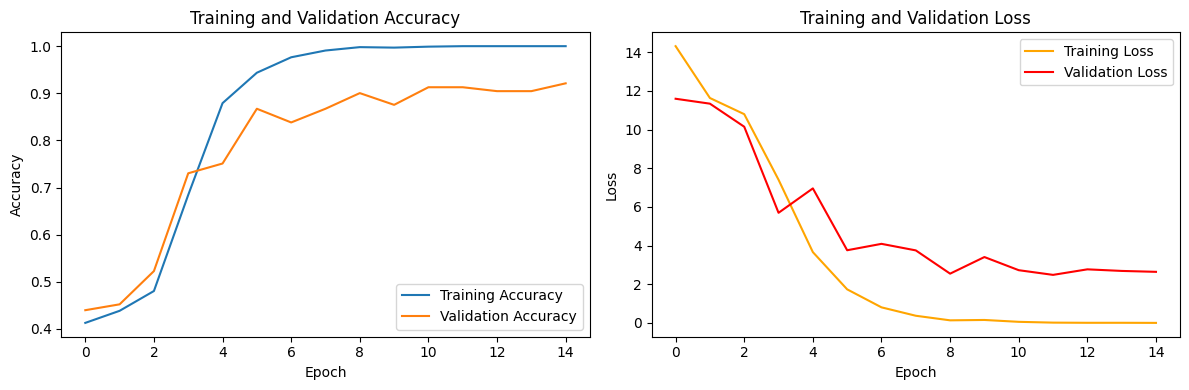

13/13 [==============================] - 2s 150ms/step


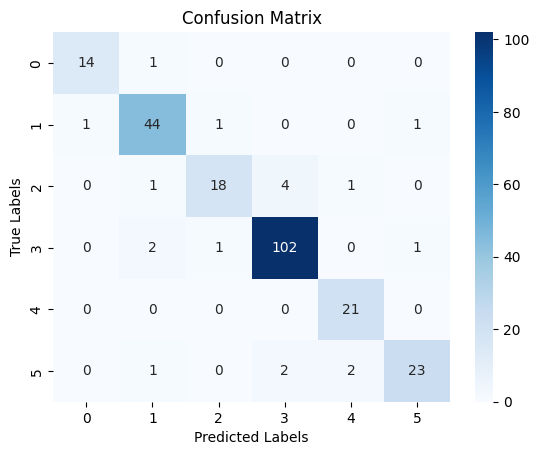


Classification Report:
                   precision    recall  f1-score   support

     Ariel_Sharon       0.93      0.93      0.93        15
     Colin_Powell       0.90      0.94      0.92        47
  Donald_Rumsfeld       0.90      0.75      0.82        24
    George_W_Bush       0.94      0.96      0.95       106
Gerhard_Schroeder       0.88      1.00      0.93        21
       Tony_Blair       0.92      0.82      0.87        28

         accuracy                           0.92       241
        macro avg       0.91      0.90      0.90       241
     weighted avg       0.92      0.92      0.92       241



In [13]:
test_generator=validation_generator
test_loss, test_accuracy = model.evaluate(test_generator)
print(f"Test Loss: {test_loss:.4f}")
print(f"Test Accuracy: {test_accuracy:.4f}")

# Plot training and validation accuracy and loss
plt.figure(figsize=(12, 4))

plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Training Loss', color='orange')
plt.plot(history.history['val_loss'], label='Validation Loss', color='red')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.tight_layout()
plt.show()

# Predictions and Confusion Matrix

# Initialize lists to store data and labels
# x_test = []
y_test = []

# Calculate the number of batches needed to process the entire dataset
num_batches = len(test_generator)

# Loop through each batch and collect data and labels
for i in range(num_batches):
    batch_x, batch_y = test_generator.next()
    # x_test.append(batch_x)
    y_test.append(batch_y)

# Convert the lists to NumPy arrays if needed
# x_test = np.concatenate(x_test, axis=0)
y_test = np.concatenate(y_test, axis=0)


y_pred = model.predict(test_generator)
# Convert predictions to label index
y_pred_argmax = tf.argmax(y_pred, axis=1)
y_test_argmax = tf.argmax(y_test, axis=1)


confusion = confusion_matrix(y_test_argmax, y_pred_argmax)
sns.heatmap(confusion, annot=True, cmap="Blues", fmt="d")
plt.title("Confusion Matrix")
plt.xlabel("Predicted Labels")
plt.ylabel("True Labels")
plt.show()

# Classification Report
class_report = classification_report(y_test_argmax, y_pred_argmax, target_names=test_generator.class_indices)
print("\nClassification Report:")
print(class_report)